## consider the effect of ephemeris uncertainies

Many transiting planets discovered with TESS will have their linear ephemerides constrained solely by the TESS data which often spans just 27 days of observations. Some of those planets' ephemerides will have sufficiently high uncertainties that our ability to predict their transits following the JWST launch date severely hindered by those uncertainties. 

Here I want to show the amplitude of those uncertainties for some planets of interest and for those with particularly uncertain transit times, how follow-up transit detections with MEarth at intermediate times between the intiial detection and the JWST launch, can aleviate those uncertainties. 

In [1]:
from imports import *
from astropy.time import Time
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [18]:
# plot uncertainty in mid-transit time over time
def plot_T0_uncertainty(P, eP, T0, eT0, D_min, title='', label=False):
    '''T0 should be in units of BJD - 2,457,000'''
    # define time array
    t0 = 2457000
    P_measured = unp.uarray(P, eP)
    T0_measured = unp.uarray(T0, eT0) + t0
    T_jwst = 2459303.5
    T0_future = T0_measured + np.arange((T_jwst-t0 + 365 - T0) / P) * P_measured
    tarr = unp.nominal_values(T0_future)-t0
    
    # plot uncertainty in mid-transit times over time
    plt.figure(figsize=(10,5))
    plt.plot(tarr, np.zeros(tarr.size), 'k-')
    for i in range(1,3):
        plt.fill_between(tarr, -i*unp.std_devs(T0_future)*24, i*unp.std_devs(T0_future)*24, color='k', alpha=.3)
    
    if np.isfinite(D_min):
        D_hrs = D_min/60.
        plt.plot(np.repeat(tarr.max(),2), np.arange(-.5,1)*D_hrs, 'k-', lw=3, 
                 label='Transit duration (%.2f hrs)'%D_hrs)
        # if the uncertainty exceeds the transit duration, highlight the time at which that happens
        if np.any(2*unp.std_devs(T0_future)[-1]*24 > D_hrs):
            g = np.where(abs(2*unp.std_devs(T0_future)*24-D_hrs) == 
                         np.min(abs(2*unp.std_devs(T0_future)*24-D_hrs)))[0][0]
            plt.plot(np.repeat(tarr[g],2), np.arange(-.5,1)*D_hrs, 'k-', lw=3)
    
    plt.xlabel('Time [BJD - 2,457,000]', fontsize=12)
    plt.ylabel('Deviation from MAP ephemeris [hours]', fontsize=12)
    plt.title(title)
    
    # highlight current date
    t = Time(time.time(), format='unix')
    plt.axvline(t.jd-t0, ls='--', color='r', lw=2, label='today')
    
    # highlight JWST launch
    plt.axvline(T_jwst-t0, ls='--', color='b', lw=3, label='JWST launch date')
    plt.axvline(T_jwst+(6*30)-t0, ls='--', color='g', lw=3, label='approximate commencement\nof GO programs')
    plt.legend(loc='upper left')
    plt.grid(color='k', alpha=.5)
    plt.xlim((tarr.min(),tarr.max()+100))
    
    # save
    if label:
        try:
            os.mkdir('plots/Ephemerides')
        except OSError:
            pass
        plt.savefig('plots/Ephemerides/T0uncertainty_%s.png'%title)

In [12]:
# TEMP to compute transit durations
P, Ms, Rs, rp, inc, aRs = 6.34, 0.6253, 0.5892, 1.97, 89.81, 20.88
b = np.cos(np.deg2rad(inc))*aRs
print b, rvs.transit_width(P, Ms, Rs, rp, b)*24*60

0.06924057518211427 142.81897310222647


In [19]:
# consider some planets with P, eP, T0-2,457,000, eT0, & T14
custom_planets = 0

if custom_planets:
    planets_dict = {'TOI-134.01': (1.4013, 0.0001, 1345.6507, 0.001, 85.43676294278201),
                    'K2-18 b': (32.93962, 1e-4, 264.39142, 6.4e-4, 159.78),
                    'LHS 1140 c': (3.77793, 3e-6, 1226.84316, .000026, 67.87208449699301),
                    'LHS 1140 b': (24.736959, 8e-5, -84.28846, 4e-5, 127.45747350107494),
                    'TOI-226.01': (20.2833, .0048, 1378.7855, .0042, 139.14240247130687),
                    'OI-278661431.01': (17.6317, 0.0048, 1343.9299, 0.0025, 134.27814579036573),
                    'OI-441056702.01': (6.3424, 0.0093, 1371.8111, 0.0055, 142.81897310222647)}

# get all TOIs    
else:
    d = np.genfromtxt('/Users/ryancloutier/Research/MEarthEphemerides/input_data/toi-2019-02-26.csv', delimiter=',',
                     usecols=(1,2,6,8,9,10,11,12))
    tics,tois,Tmag,T0s,eT0s,Ps,ePs,Ds = d.T
    planets_dict = {}
    for i in range(tics.size):
        if np.all(np.isfinite(d[i])):
            planets_dict['TIC%s'%tics[i]] = (Ps[i], ePs[i], T0s[i], eT0s[i], Ds[i]*60)

KeyboardInterrupt: 

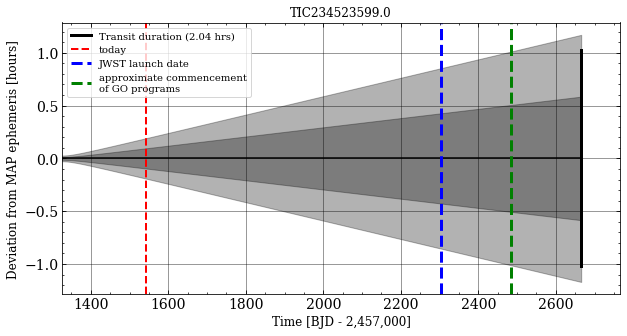

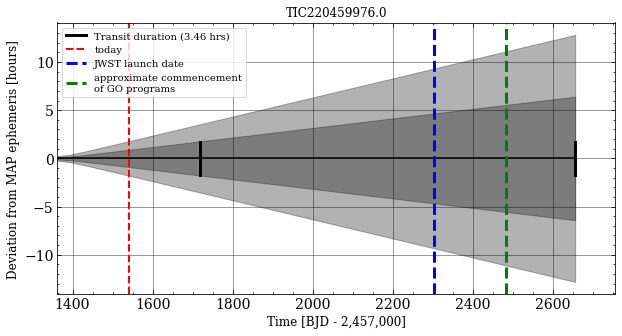

In [ ]:
# plots
for p in planets_dict:
    plot_T0_uncertainty(*planets_dict[p], title=p, label=True)